**Задание**

Проанализируйте 6 временных рядов из папки Series и сделайте их стационарными:

- monthly-sales-of-company-x-jan-6.csv
- monthly-boston-armed-robberies-j.csv
- international-airline-passengers.csv
- mean-monthly-air-temperature-deg.csv
- weekly-closings-of-the-dowjones-.csv
- daily-total-female-births-in-cal.csv

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [ ]:
sales_of_company_x = pd.read_csv("/content/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("/content/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("/content/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("/content/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("/content/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("/content/daily-total-female-births-in-cal.csv")

**Отобразим графики временных рядов**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

'''
%matplotlib inline - вывод команд построения графика отображается во внешних интерфейсах
(напр. блокнот Jupyter) непосредственно под ячейкой кода, которая его создала.
Полученные графики также будут сохранены в документе записной книжки.
'''

'\n%matplotlib inline - вывод команд построения графика отображается во внешних интерфейсах\n(напр. блокнот Jupyter) непосредственно под ячейкой кода, которая его создала.\nПолученные графики также будут сохранены в документе записной книжки.\n'

In [ ]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

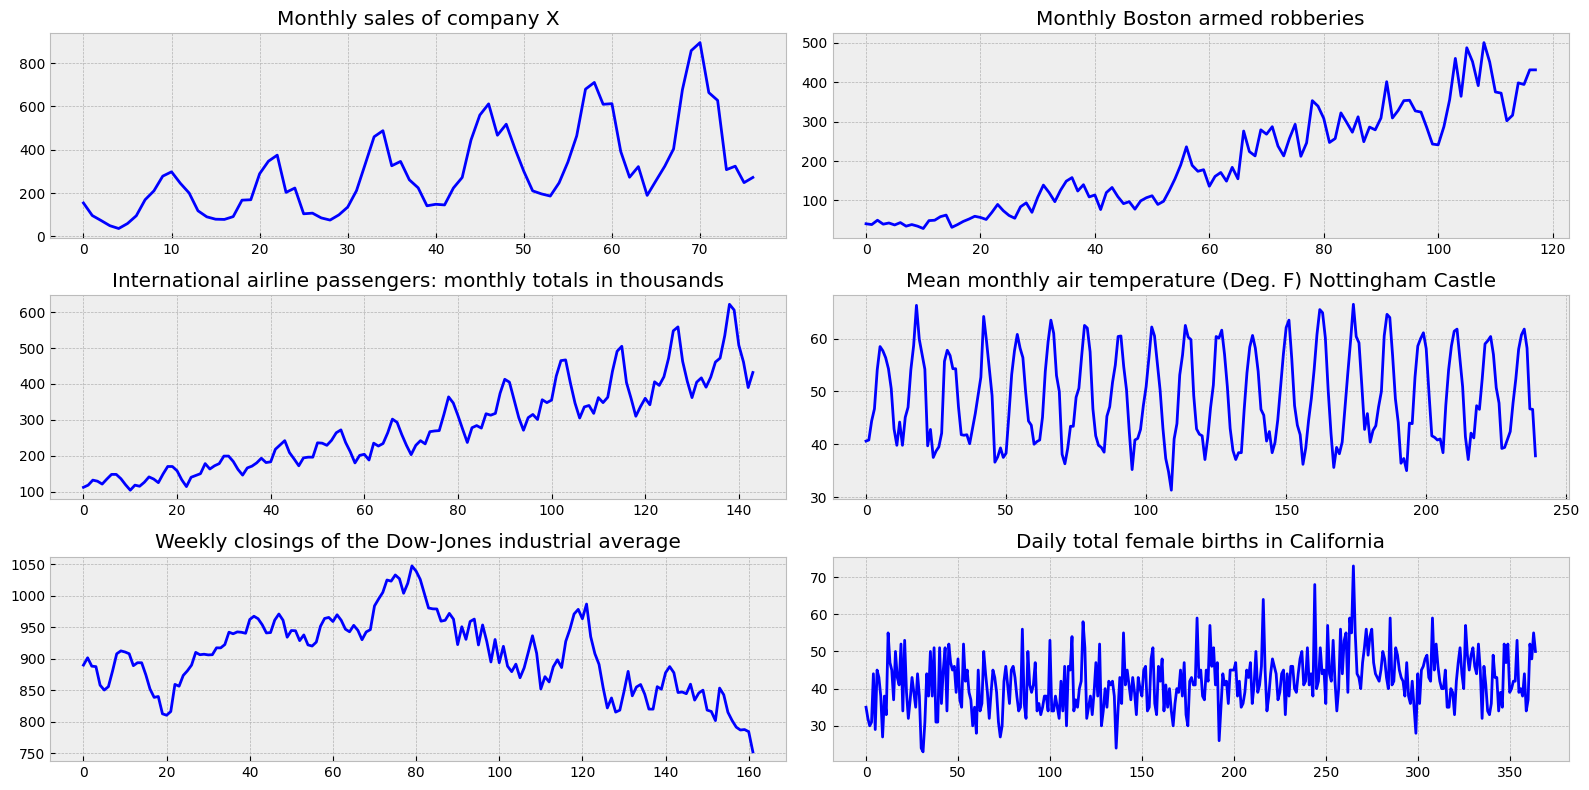

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

**1. Анализ временного ряда "Monthly sales of company X"**

Зададим функцию для проверки гипотезы о нестационарности ряда, используя тест Дики-Фуллера

In [ ]:
'''
Функция для использования теста Дики-Фуллера
для проверки временного ряда на стационарность
'''

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

Построим график автокорреляции, частичной автокорреляции
для визуального анализа наличия/отсутствия элементов временного ряда (тренд/сезонность/размах/шум)

In [ ]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Посмотрим на исходный временной ряд



Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


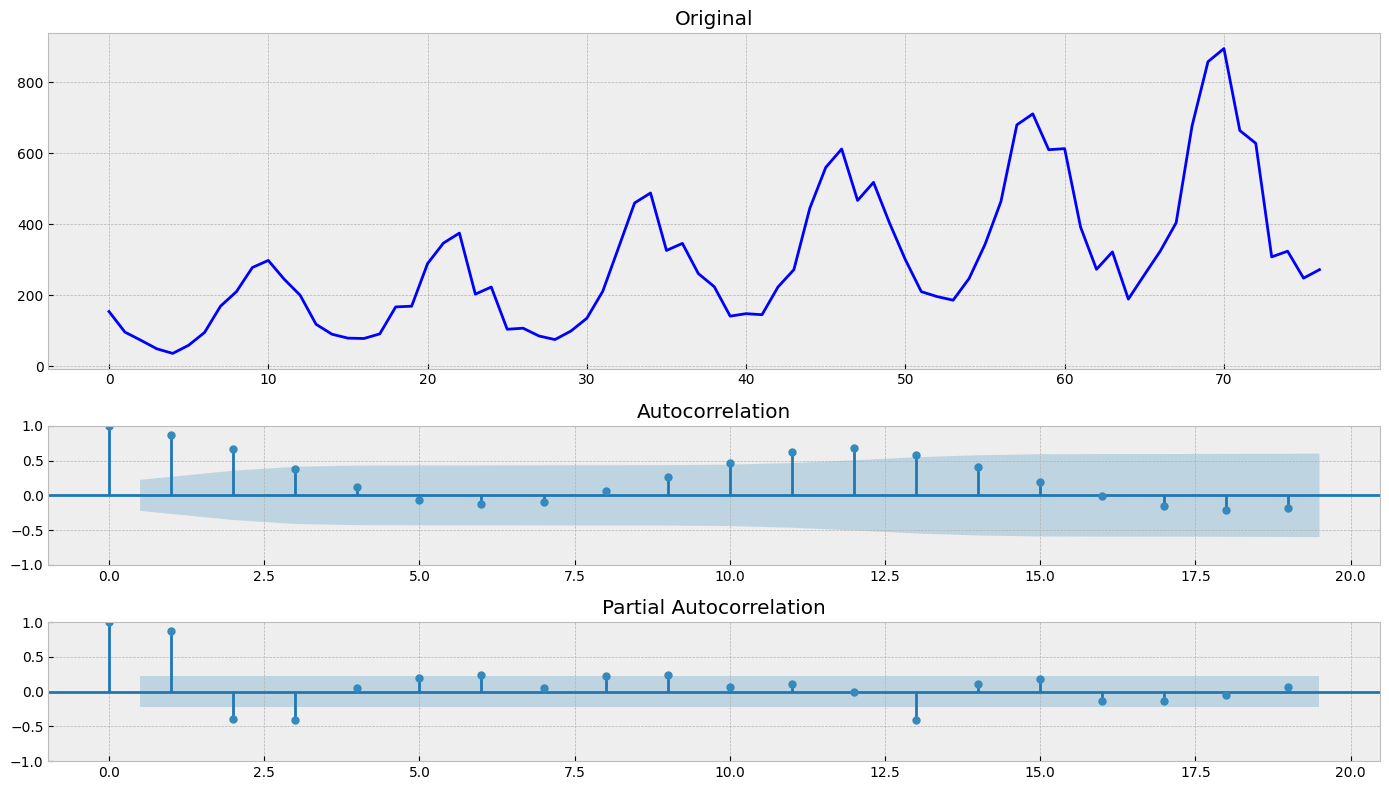

In [ ]:
tsplot(sales_of_company_x['Count'])

Визуально временной ряд "Monthly sales of company X" не стационарен, поскольку:
1. График не похож на шум
2. Есть сезонность
3. Заметен восходщий тренд
4. Дисперсия увеличивается со временем

Значение p-value > 0,05 (по тесту Дики-Фуллера). Значит, временной ряд не стационарен, значения в нем зависят от времени.

**Нормализуем дисперсию**

Нормализацию дисперсии произведем через преобразование Бокса-Кокса — это метод преобразования ненормально распределенного набора данных в более нормально распределенный .

In [ ]:
sales_of_company_x_stat, best_lambda = boxcox(sales_of_company_x['Count'])

In [ ]:
print(f'Оптимальная лямбда - {best_lambda:.4f}')

Оптимальная лямбда - 0.2109


Results of Dickey-Fuller Test:
Test Statistic                 -0.631279
p-value                         0.863757
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


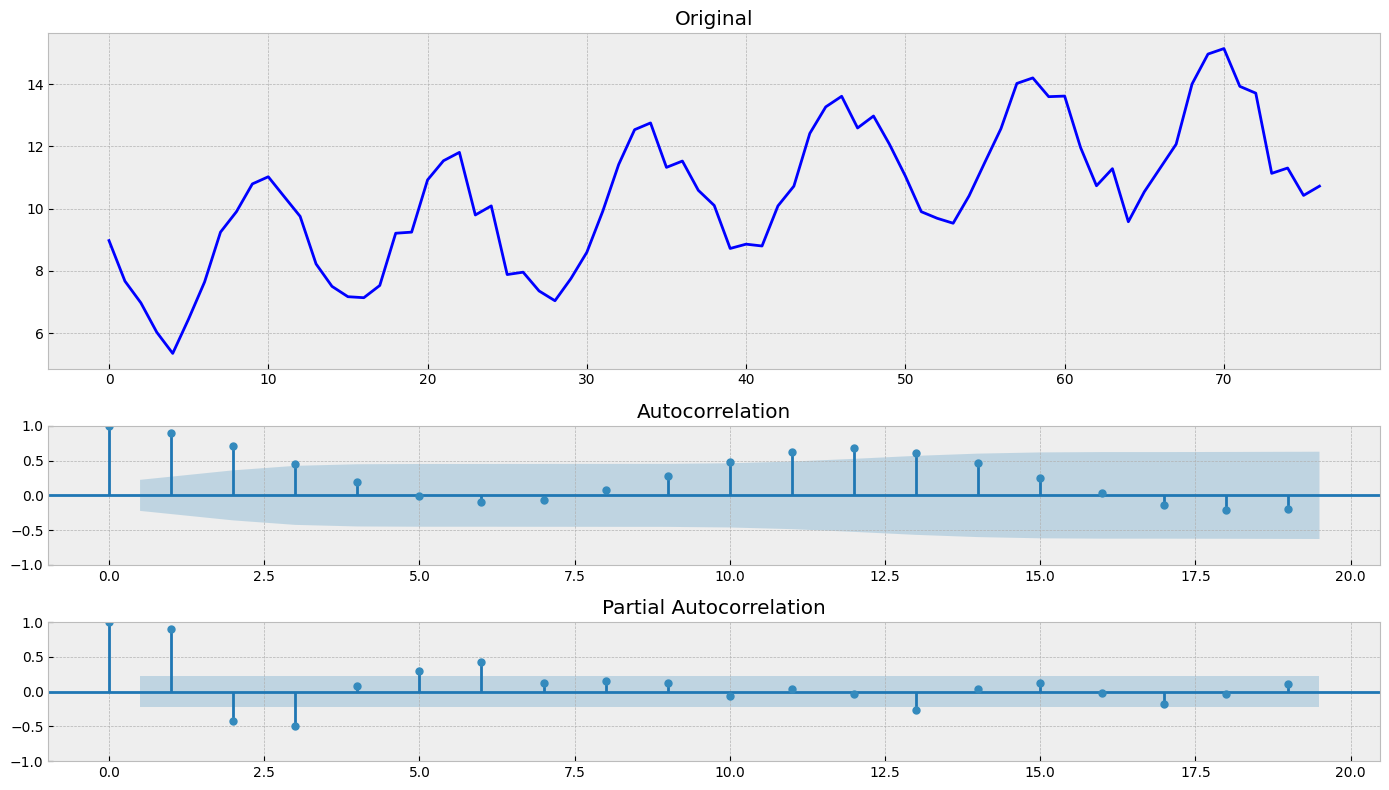

In [ ]:
tsplot(sales_of_company_x_stat)

После преобразования дисперсия нормализована (постоянна), но остались тренд и сезонность.

**Убираем тренд, используя дифференцирование**

In [ ]:
sales_of_company_x_stat = np.diff(sales_of_company_x_stat, 1)

Results of Dickey-Fuller Test:
Test Statistic                 -3.284204
p-value                         0.015599
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


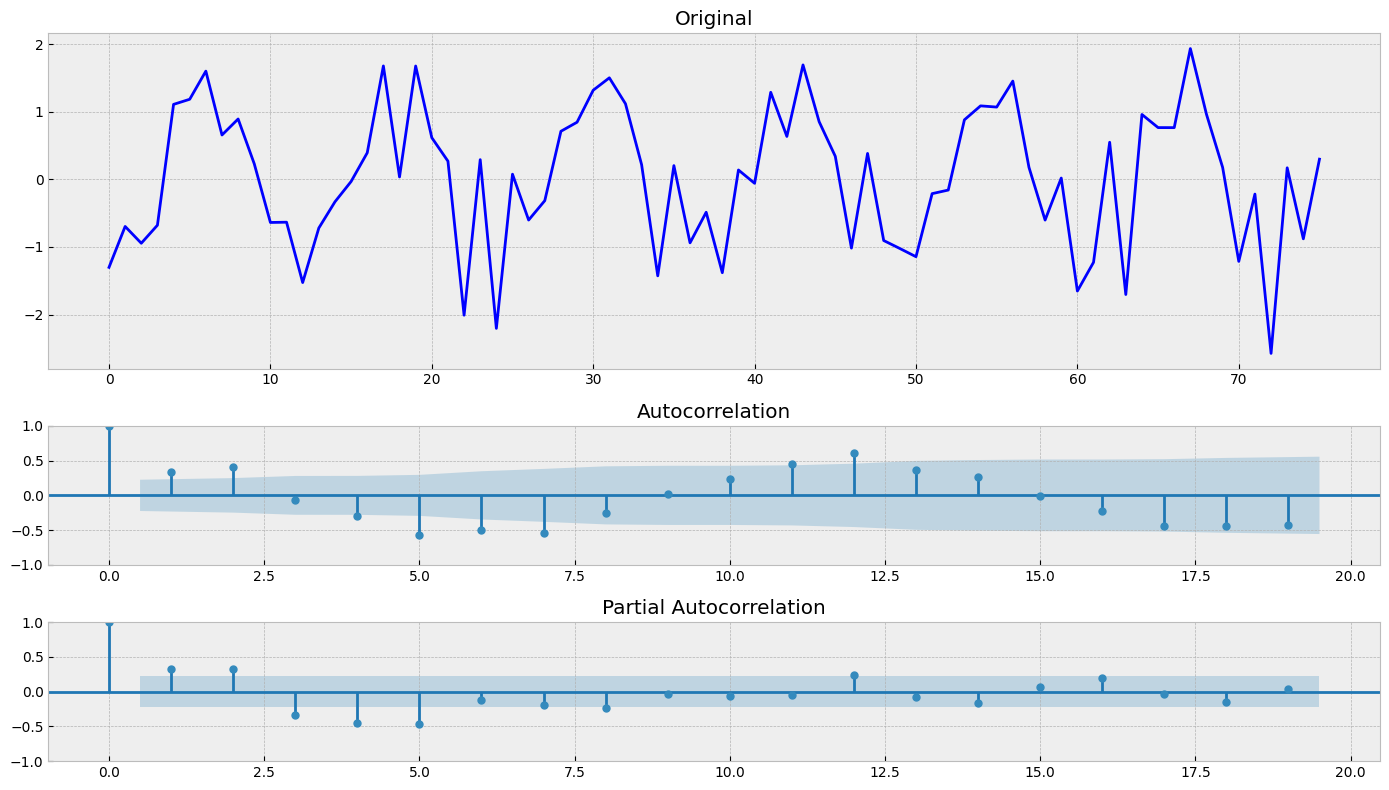

In [ ]:
tsplot(sales_of_company_x_stat)

Значение p-value < 0,05, но, как следует из коррелограммы, осталась сезонность (с периодичностью 12).

**Убираем сезонность**

In [ ]:
sales_of_company_x_stat = sales_of_company_x_stat[12:] - sales_of_company_x_stat[:-12]

Results of Dickey-Fuller Test:
Test Statistic                 -2.351250
p-value                         0.155971
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


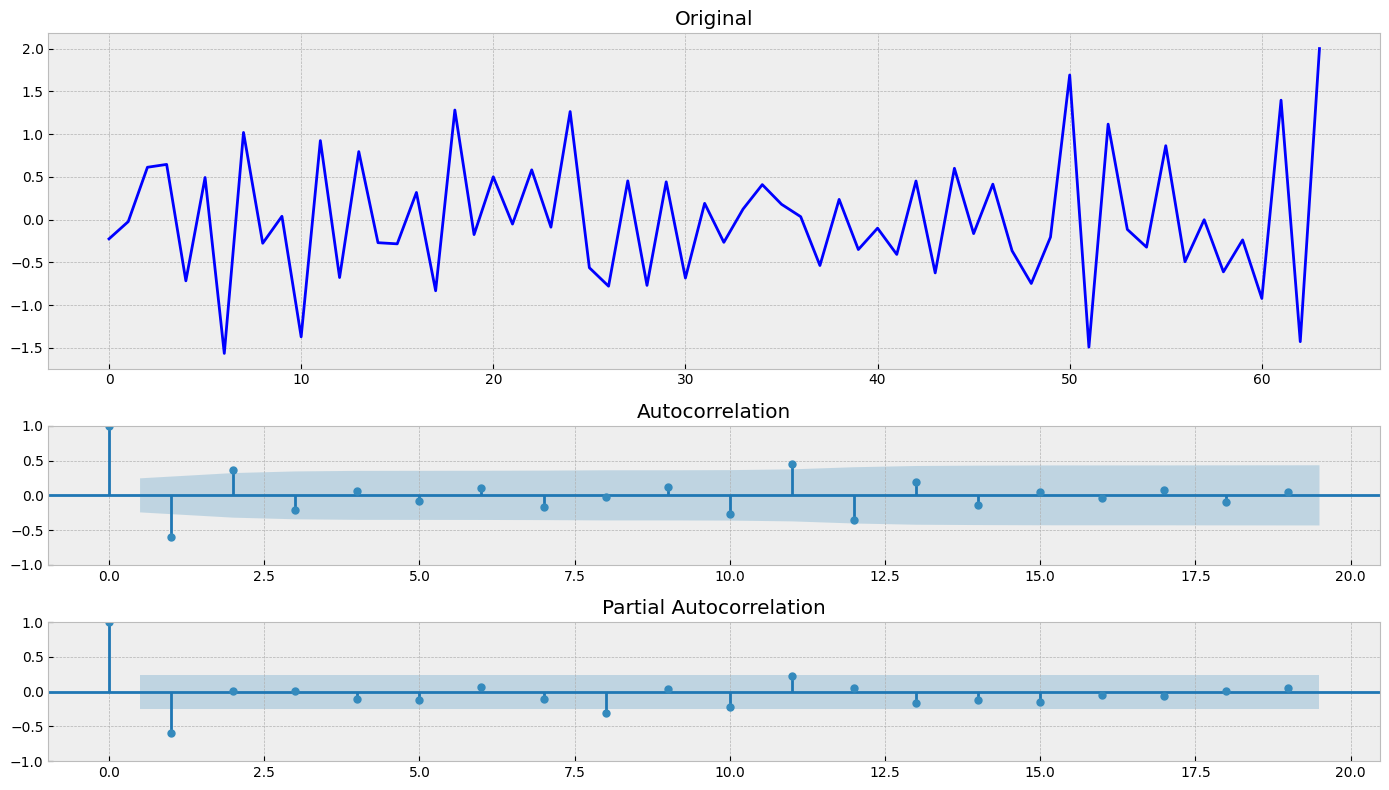

In [ ]:
tsplot(sales_of_company_x_stat)

После преобразования значение p-value > 0,05. По графику автокорреляции видно, что есть влияние сезонности (с периодичностью 11). Уберем её.

In [ ]:
sales_of_company_x_stat = sales_of_company_x_stat[11:] - sales_of_company_x_stat[:-11]

Results of Dickey-Fuller Test:
Test Statistic                -1.168927e+01
p-value                        1.667906e-21
#Lags Used                     0.000000e+00
Number of Observations Used    5.200000e+01
Critical Value (1%)           -3.562879e+00
Critical Value (5%)           -2.918973e+00
Critical Value (10%)          -2.597393e+00
dtype: float64


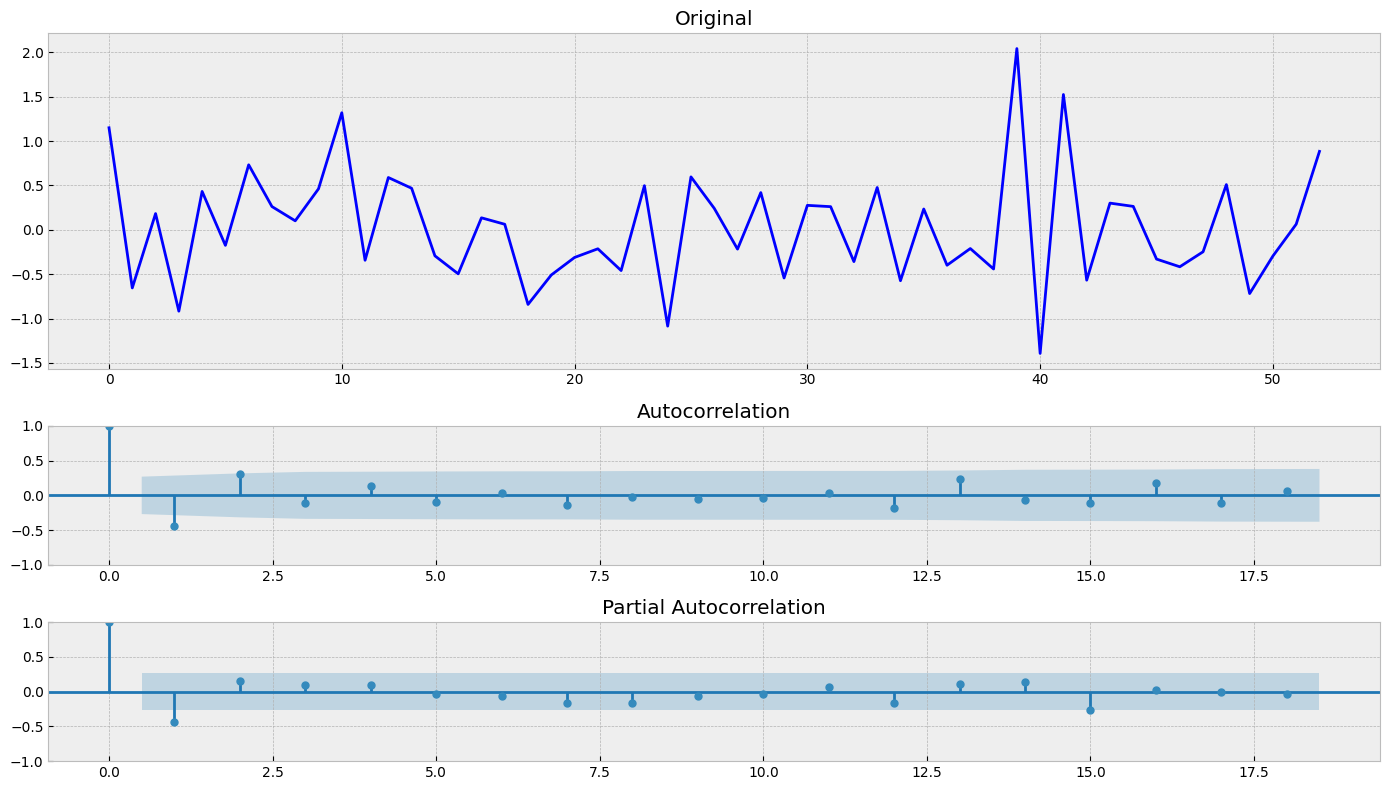

In [ ]:
tsplot(sales_of_company_x_stat)

Значение p-value < 0,05.

Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда.

Исследуемый временной ряд приведен к стационарному виду.

**2. Анализ временного ряда "Monthly Boston armed robberies"**


Посмотрим на исходный временной ряд

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


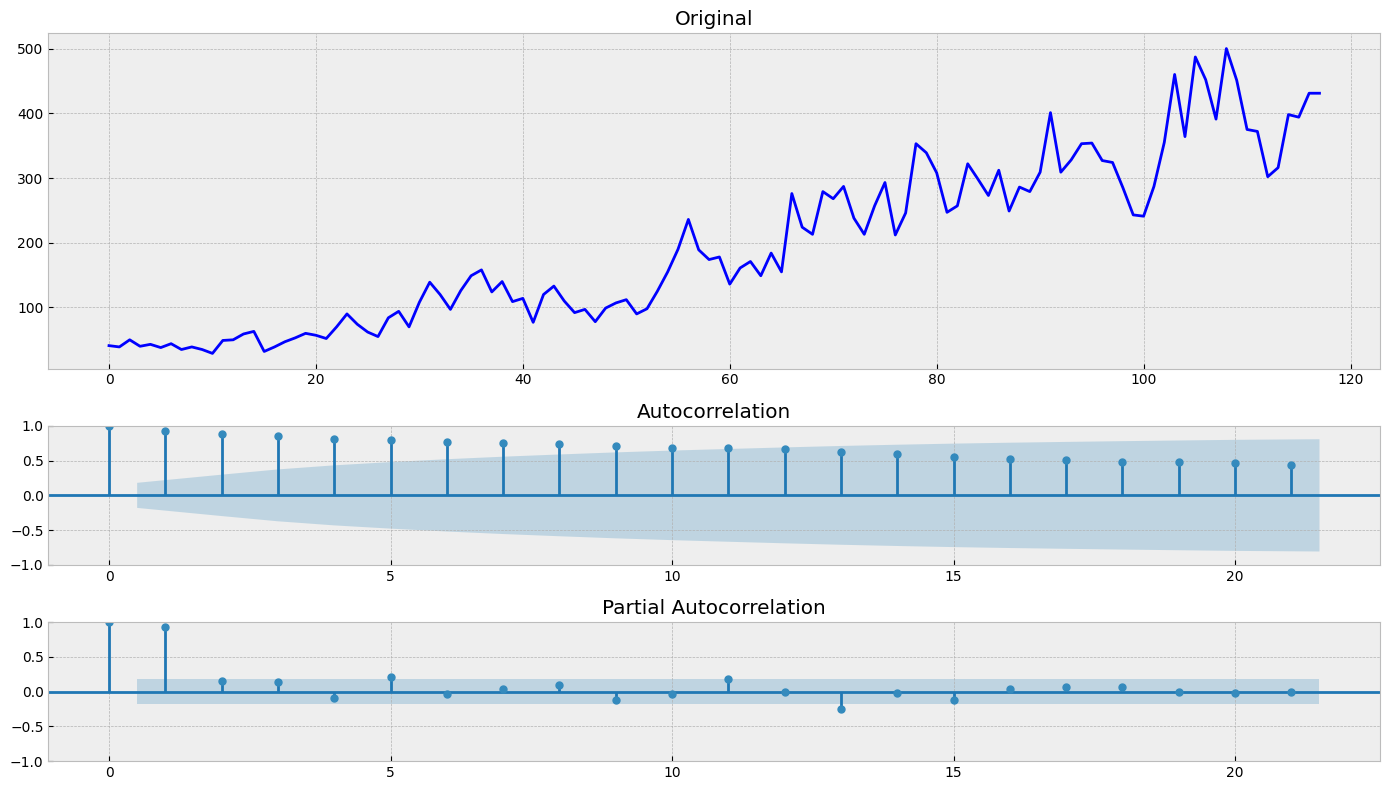

In [ ]:
tsplot(robberies_in_boston['Count'])

Визуально временной ряд "Monthly Boston armed robberies" не стационарен, поскольку:
1. График не похож на шум
2. Заметен восходящий тренд
3. Вероятно, непостоянная дисперсия

Значение p-value сильно > 0,05 (по тесту Дики-Фуллера). Значит, временной ряд не стационарен, значения в нем зависят от времени.

**Нормализуем дисперсию**

In [ ]:
robberies_in_boston_stat, best_lambda = boxcox(robberies_in_boston['Count'])

In [ ]:
print(f'Оптимальная лямбда - {best_lambda:.4f}')

Оптимальная лямбда - 0.3168


Results of Dickey-Fuller Test:
Test Statistic                  -0.876346
p-value                          0.795662
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


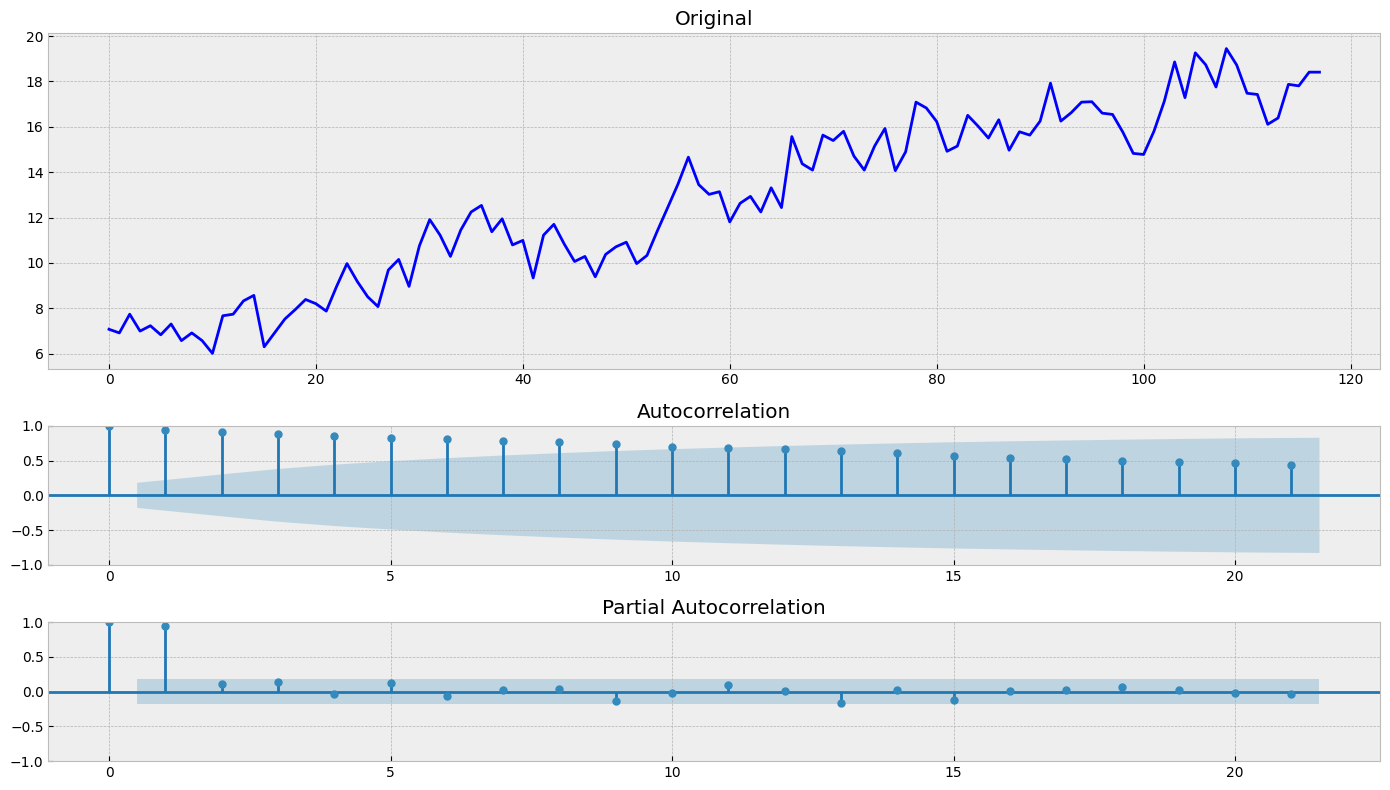

In [ ]:
tsplot(robberies_in_boston_stat)

Значение p-value немного снизилось, но все равно больше 0,05. Заметно влияние тренда.

**Убираем тренд**

In [ ]:
robberies_in_boston_stat = np.diff(robberies_in_boston_stat, 1)

Results of Dickey-Fuller Test:
Test Statistic                -5.862061e+00
p-value                        3.392204e-07
#Lags Used                     1.000000e+01
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64


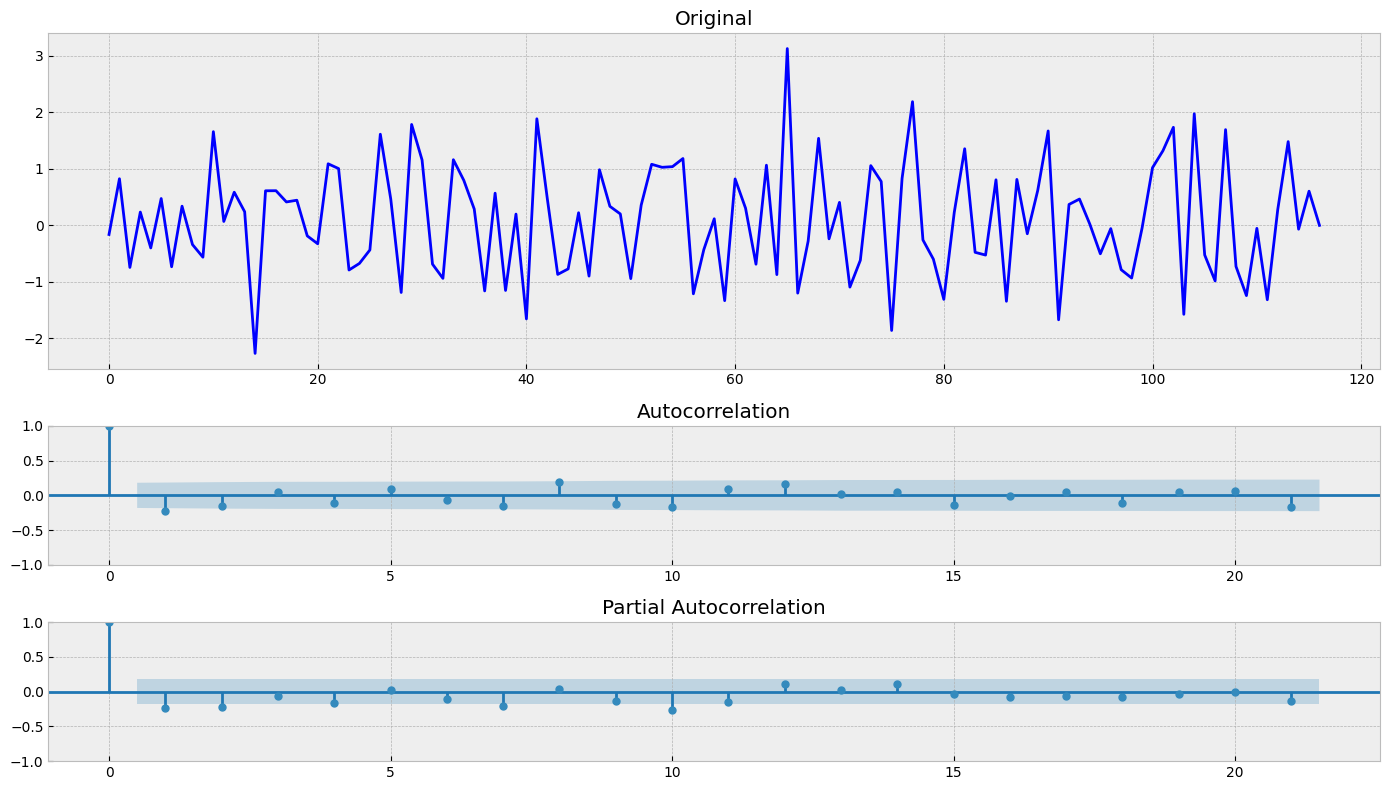

In [ ]:
tsplot(robberies_in_boston_stat)

Значение p-value < 0,05.

Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда.

Исследуемый временной ряд приведен к стационарному виду.

**3. Анализ временного ряда "International airline passengers"**


Посмотрим на исходный временной ряд

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


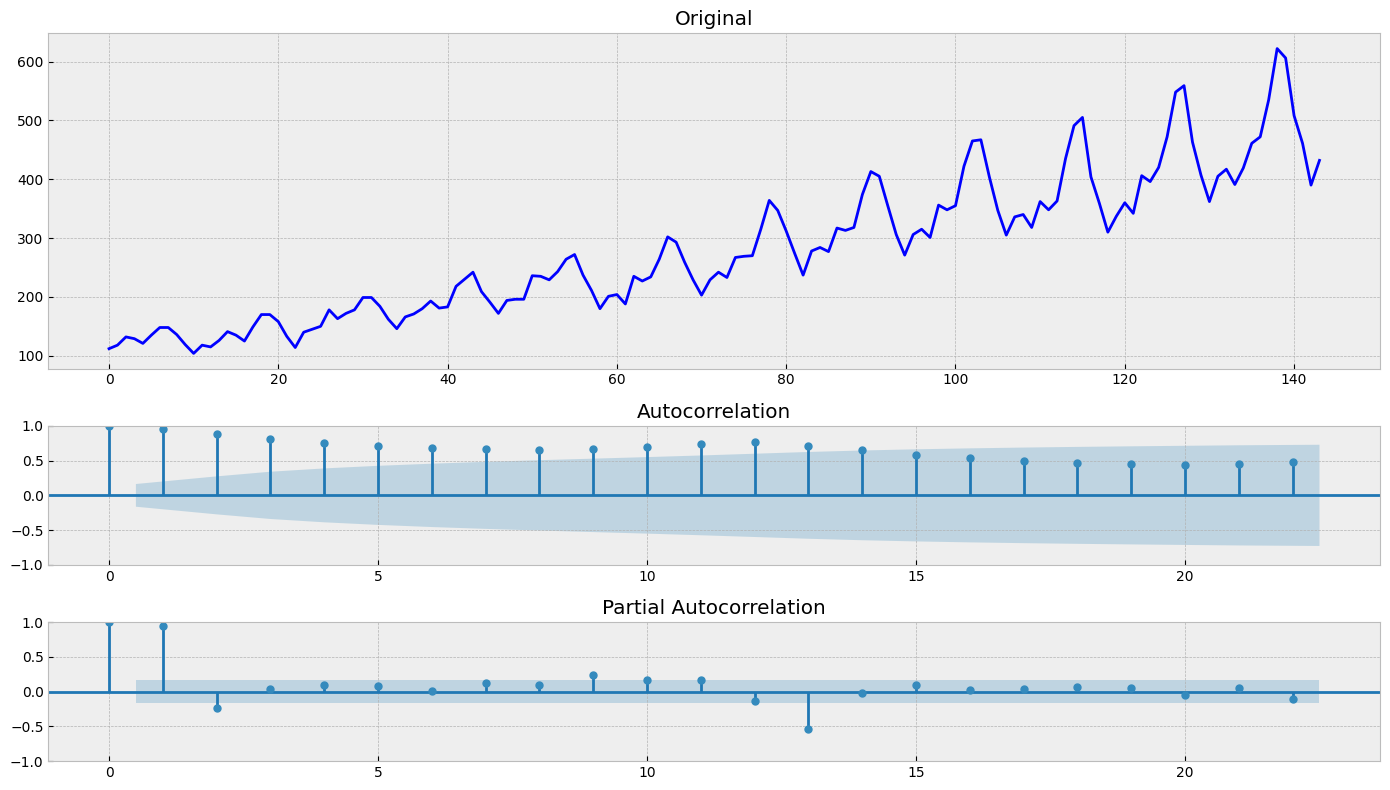

In [ ]:
tsplot(airlines_passengers['Count'])

Визуально временной ряд "International airline passengers" не стационарен, поскольку:
1. График не похож на шум
2. Есть сезонность
3. Заметен восходщий тренд
4. Дисперсия монотонно увеличиается со временем

Значение p-value > 0,05 (по тесту Дики-Фуллера). Значит, временной ряд не стационарен, значения в нем зависят от времени.

**Нормализуем дисперсию**

In [ ]:
airlines_passengers_stat, best_lambda = boxcox(airlines_passengers['Count'])

In [ ]:
print(f'Оптимальная лямбда - {best_lambda:.4f}')

Оптимальная лямбда - 0.1480


Results of Dickey-Fuller Test:
Test Statistic                  -1.326071
p-value                          0.617162
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


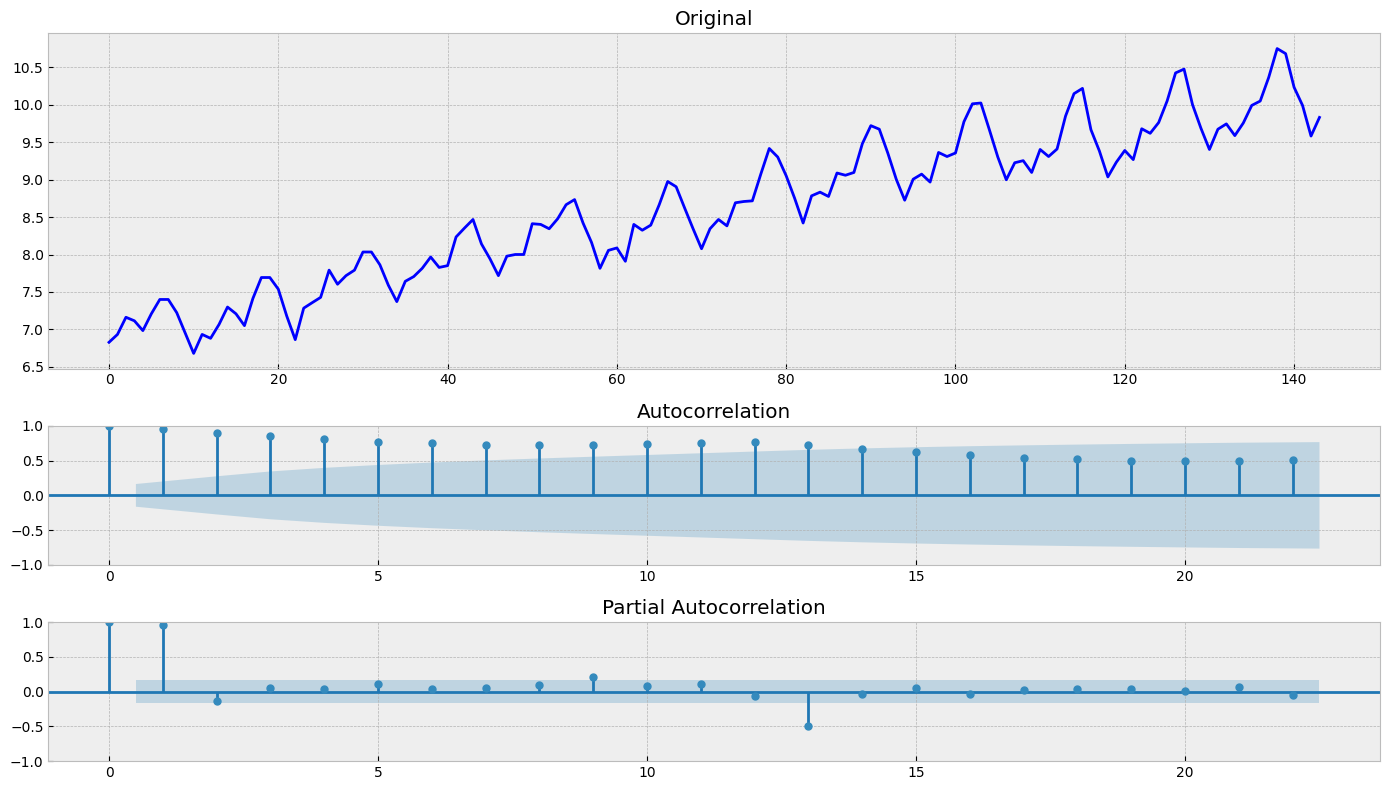

In [ ]:
tsplot(airlines_passengers_stat)

Значение p-value немного снизилось, но все равно больше 0,05. Заметно влияние тренда.

**Убираем тренд**

In [ ]:
airlines_passengers_stat = np.diff(airlines_passengers_stat, 1)

Results of Dickey-Fuller Test:
Test Statistic                  -2.871707
p-value                          0.048738
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


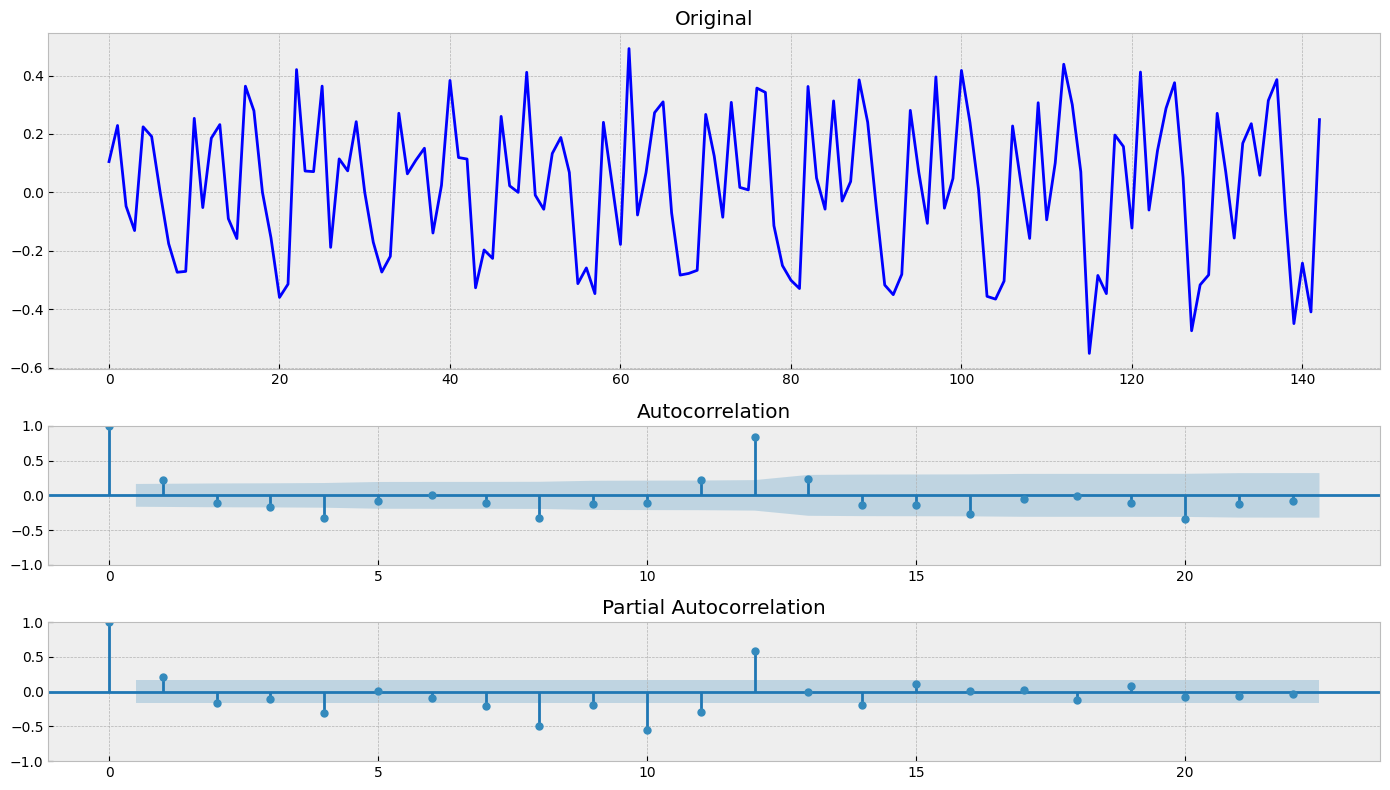

In [ ]:
tsplot(airlines_passengers_stat)

Значение p-value чуть < 0,05.

Вместе с тем по коррелограмме заметно сильное влияние сезонности (с периодичностью 12).

Поскольку стационарный ряд не должен содержать видимых закономерностей, то от сезонности необходимо избавиться

**Убираем сезонность**

In [ ]:
airlines_passengers_stat = airlines_passengers_stat[12:] - airlines_passengers_stat[:-12]

Results of Dickey-Fuller Test:
Test Statistic                  -4.393873
p-value                          0.000304
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


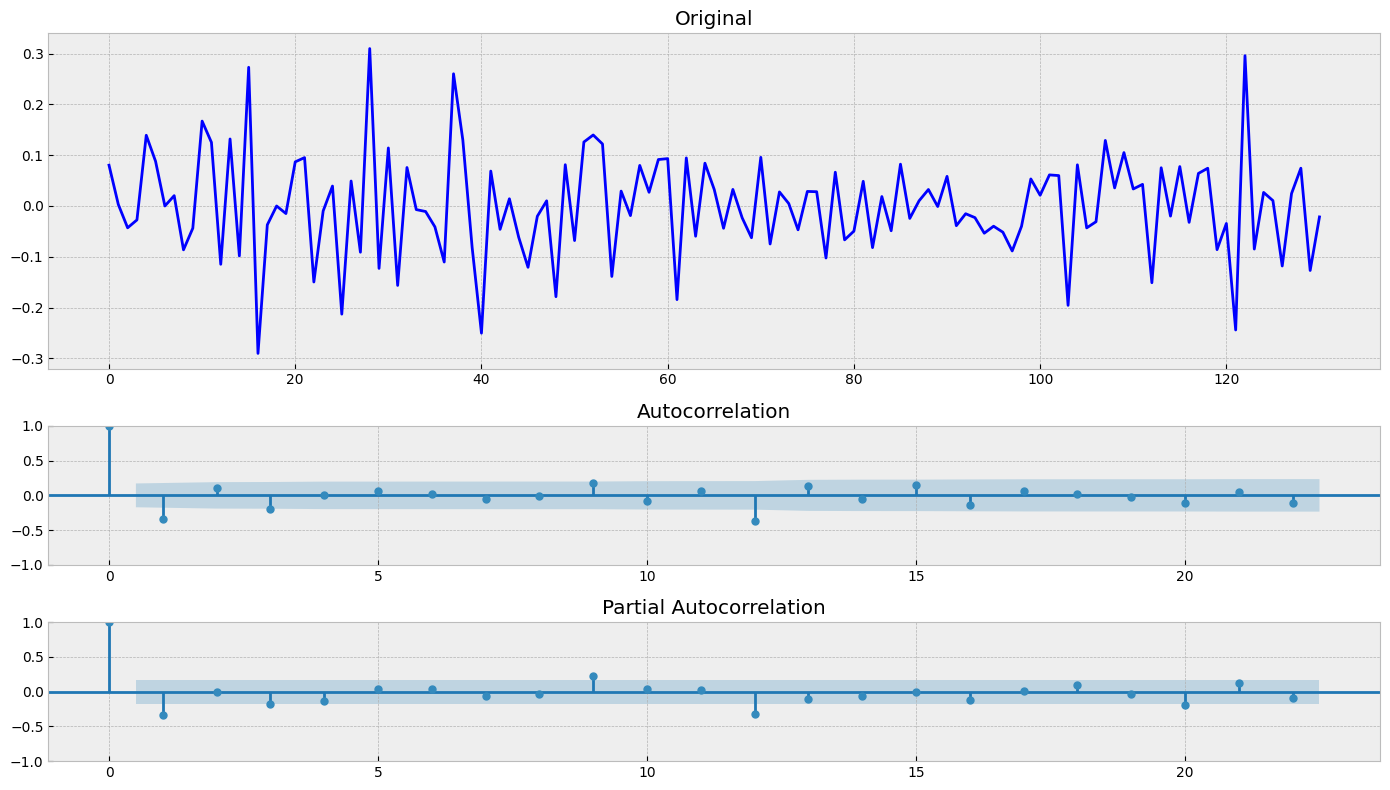

In [ ]:
tsplot(airlines_passengers_stat)

Значение p-value < 0,05.

Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда.

Исследуемый временной ряд приведен к стационарному виду.

**4. Анализ временного ряда "Mean monthly air temperature (Deg. F) Nottingham Castle"**


Посмотрим на исходный временной ряд

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


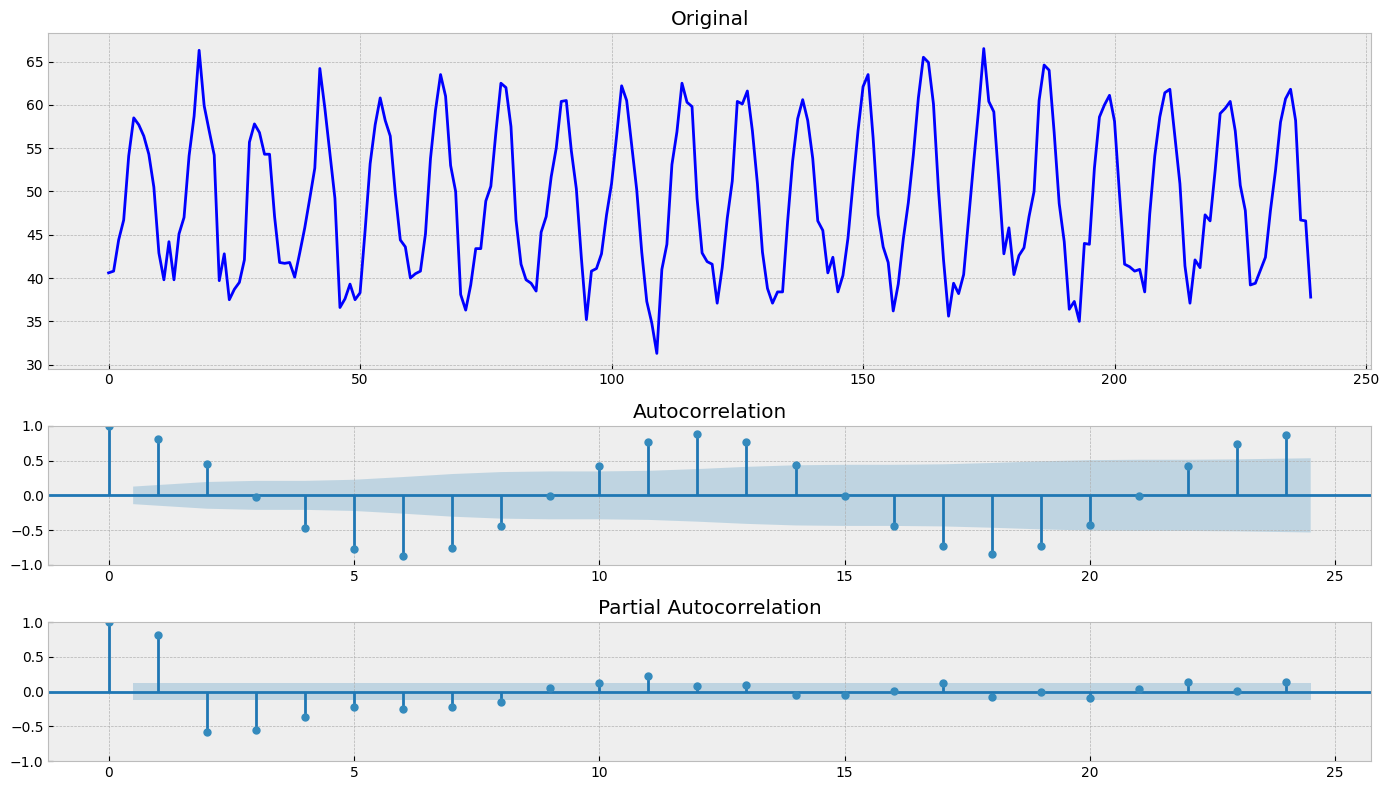

In [ ]:
tsplot(mean_monthly_temp['Deg'])

Визуально временной ряд "Mean monthly air temperature (Deg. F) Nottingham Castle" не стационарен, поскольку:
1. График не похож на шум
2. Есть сезонность
3. Возможно, непостоянная дисперсия



Значение p-value < 0,05.
Вместе с тем по коррелограмме заметно сильное влияние сезонности (с периодичностью 6/12).
Поскольку стационарный ряд не должен содержать видимых закономерностей, то от сезонности необходимо избавиться

**Нормализуем дисперсию**

In [ ]:
mean_monthly_temp_stat, best_lambda = boxcox(mean_monthly_temp['Deg'])

In [ ]:
print(f'Оптимальная лямбда - {best_lambda:.4f}')

Оптимальная лямбда - 0.0657


Results of Dickey-Fuller Test:
Test Statistic                  -3.736591
p-value                          0.003627
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


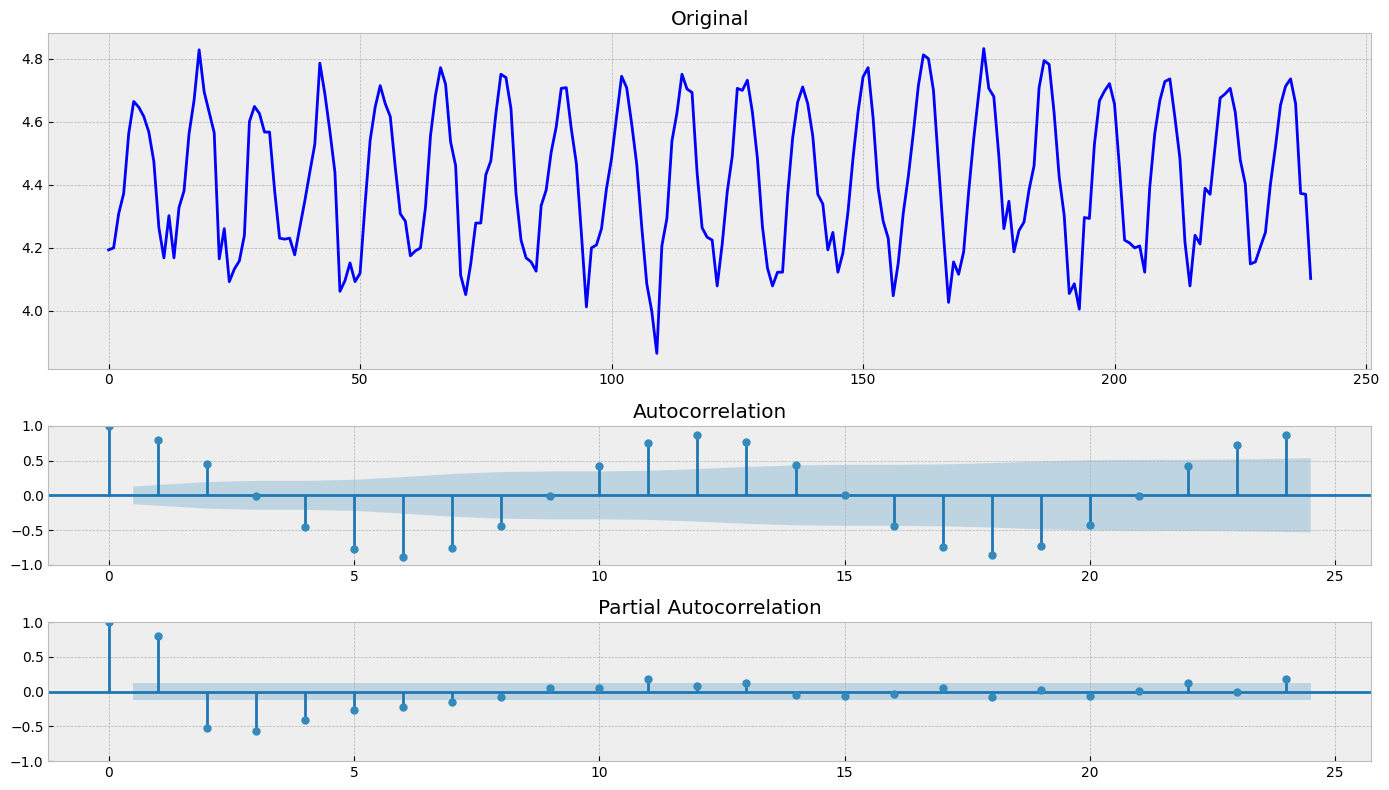

In [ ]:
tsplot(mean_monthly_temp_stat)

Стало чуть лучше, но заметно влияние сезонности.

**Убираем сезонность**

In [ ]:
mean_monthly_temp_stat = mean_monthly_temp_stat[12:] - mean_monthly_temp_stat[:-12]

Results of Dickey-Fuller Test:
Test Statistic                -6.390511e+00
p-value                        2.111642e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


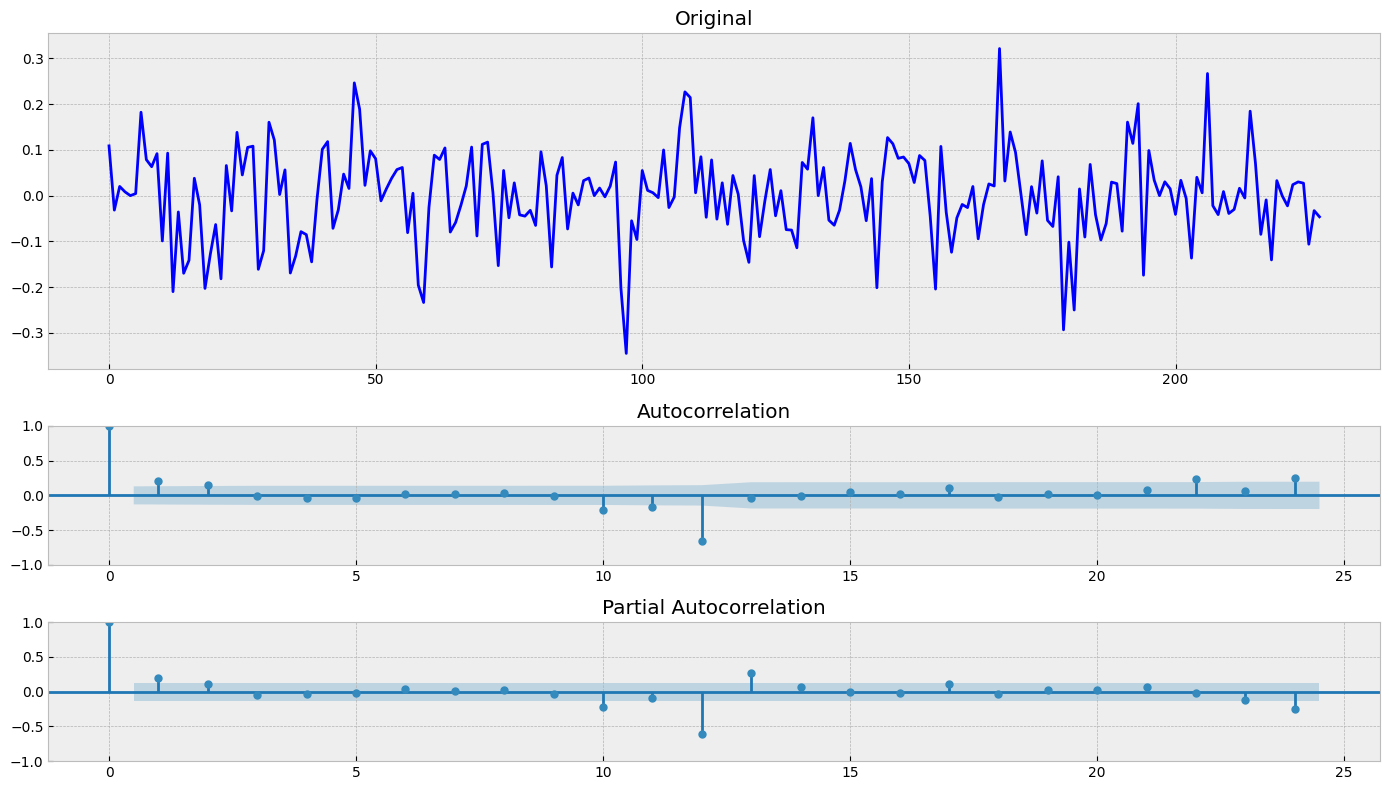

In [ ]:
tsplot(mean_monthly_temp_stat)

Значение p-value < 0,05.

Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда.

Исследуемый временной ряд приведен к стационарному виду.

**5. Анализ временного ряда "Weekly closings of the Dow-Jones industrial average"**


Посмотрим на исходный временной ряд

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


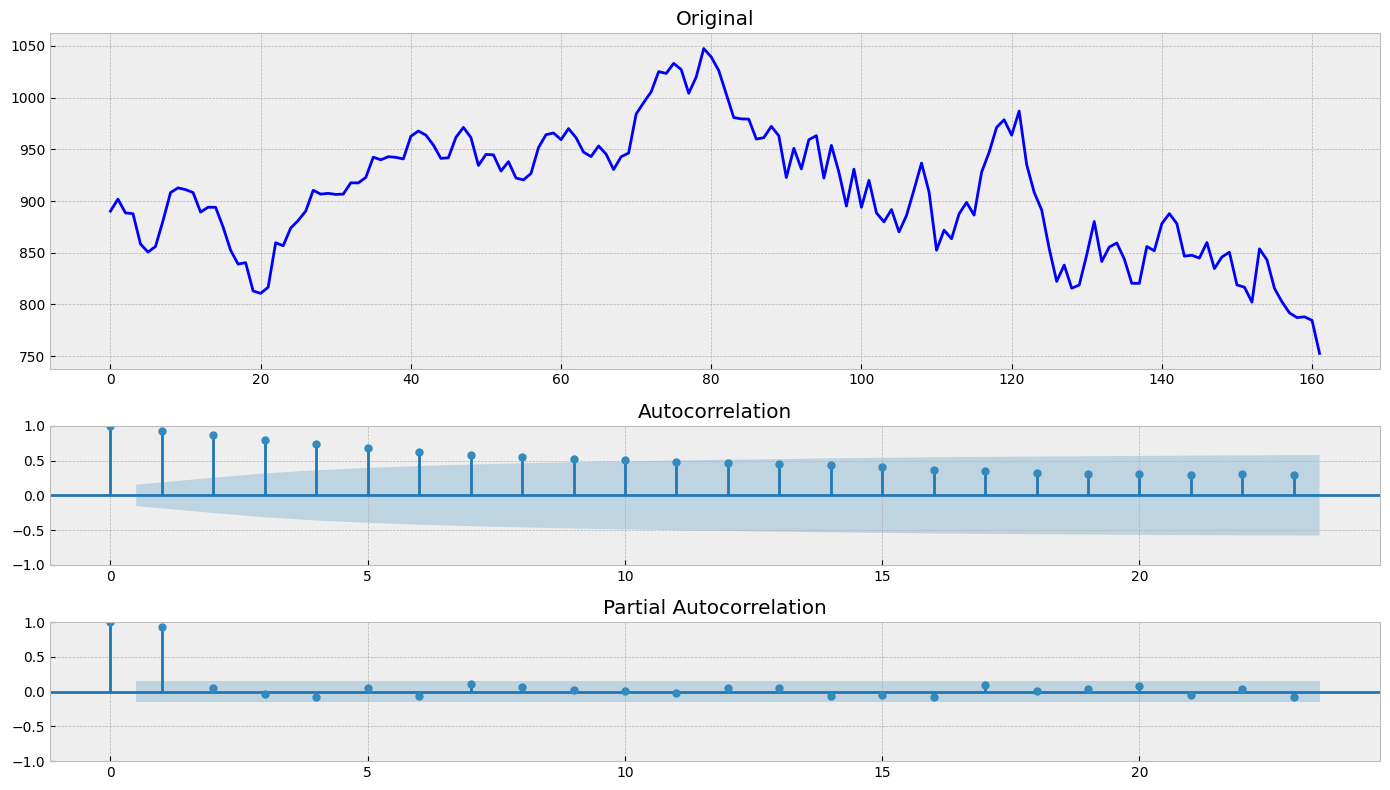

In [ ]:
tsplot(dowjones_closing['Close'])

Визуально временной ряд "Weekly closings of the Dow-Jones industrial average" не стационарен, поскольку:
1. График не похож на шум
2. Заметна трендовая составляющая
3. Непостоянная дисперсия

Значение p-value > 0,05 (по тесту Дики-Фуллера). Значит, временной ряд не стационарен, значения в нем зависят от времени.

**Нормализуем дисперсию**

In [ ]:
dowjones_closing_stat, best_lambda = boxcox(dowjones_closing['Close'])

In [ ]:
print(f'Оптимальная лямбда - {best_lambda:.4f}')

Оптимальная лямбда - 1.1328


Results of Dickey-Fuller Test:
Test Statistic                  -1.327773
p-value                          0.616372
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


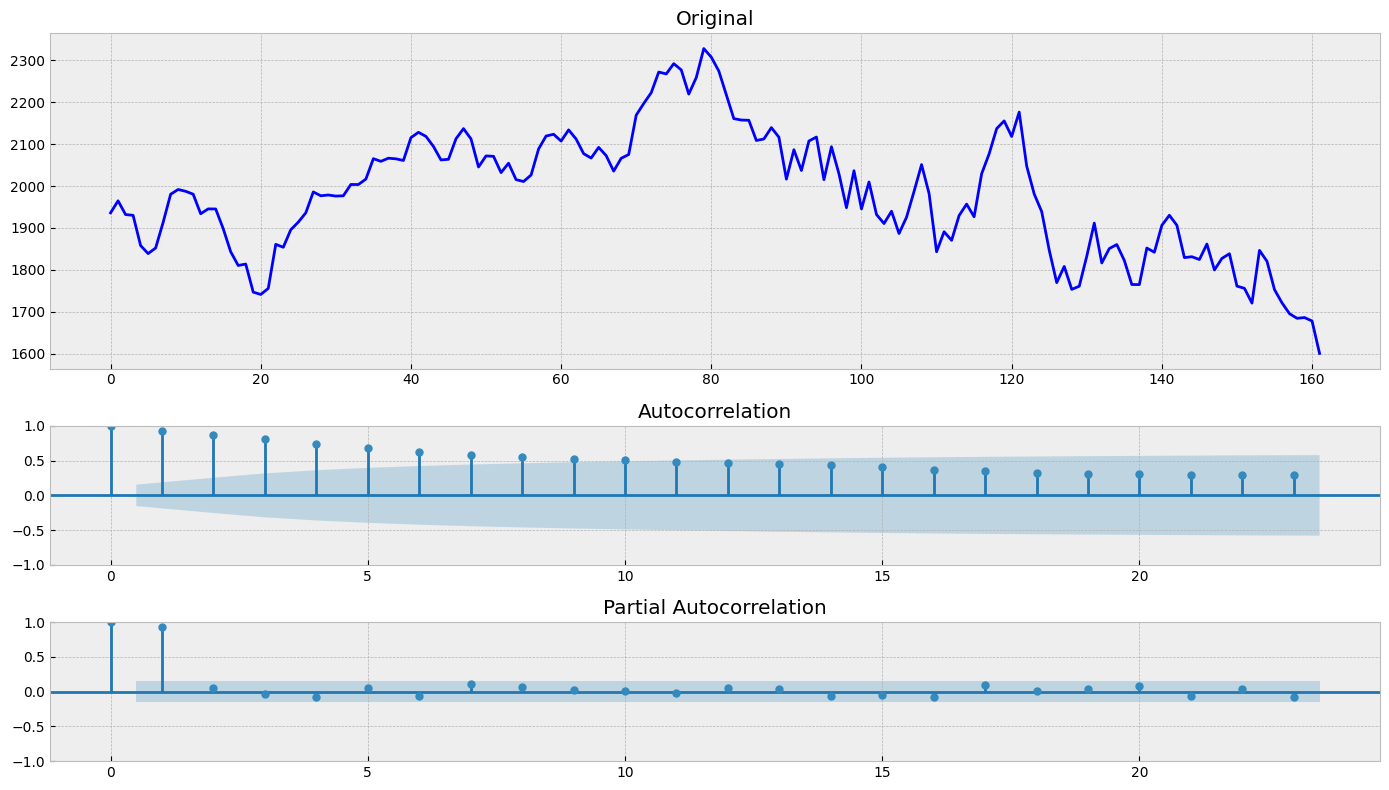

In [ ]:
tsplot(dowjones_closing_stat)

Нормализация дисперсия не привела к видимым результатам. По коррелограмме заметен тренд.

**Убираем тренд**

In [ ]:
dowjones_closing_stat = np.diff(dowjones_closing_stat, 1)

Results of Dickey-Fuller Test:
Test Statistic                -1.302750e+01
p-value                        2.382691e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


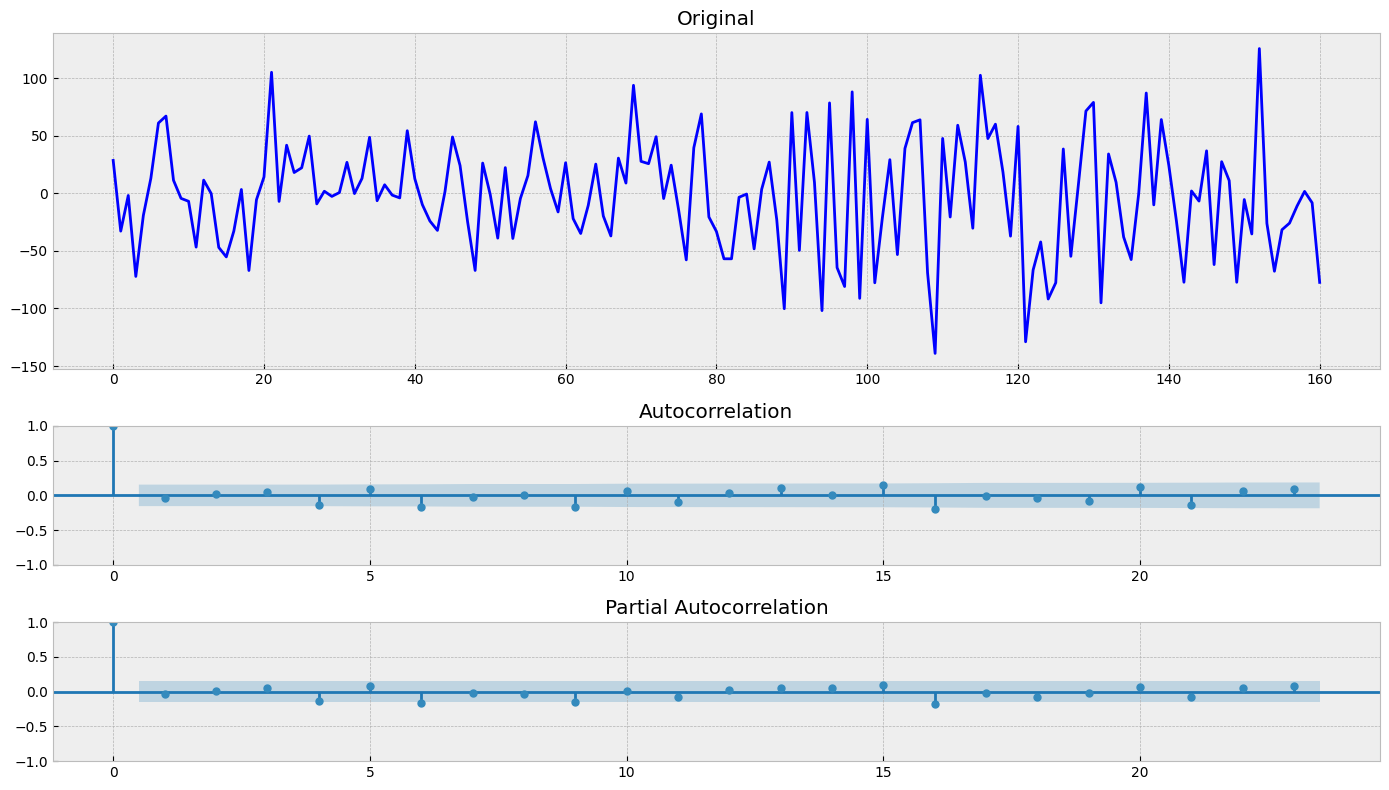

In [ ]:
tsplot(dowjones_closing_stat)

Значение p-value < 0,05.

Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда.

Исследуемый временной ряд приведен к стационарному виду.

**6. Анализ временного ряда "Daily total female births in California"**

Посмотрим на исходный временной ряд

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


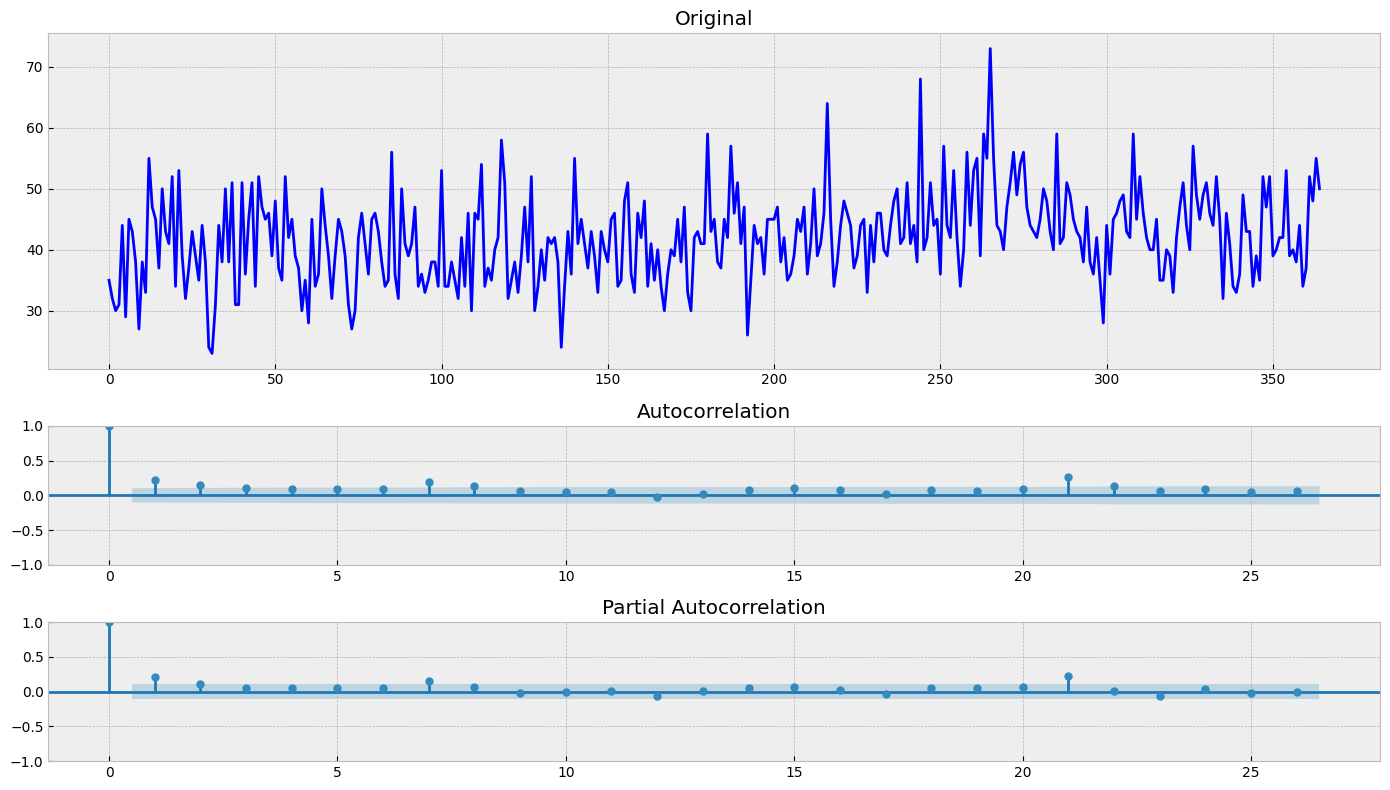

In [ ]:
tsplot(female_births['Count'])

Визуально временной ряд "Daily total female births in California" стационарен, поскольку:
1. График похож на шум
2. Сезонность не наблюдается
3. Трендовая составляющая не прослеживается
4. Дисперсия устойчивая

Значение p-value < 0,05 (по тесту Дики-Фуллера). Значит, временной ряд стационарен, значения в нем не зависят от времени, средняя и дисперсия постоянны.